# Tanzanian Water Wells

## Overview

Tanzania struggles with providing clean water to the people of its country. The goal of this analysis is to use data from existing wells throughout the country to identify the wells in need of repair. 

This analysis is focused on assisting the Tanzanian Government reduce resources spent to identify water wells that are in need of repair to ensure that clean water is available to its citizens. 

**Important Note:** Due to the runtime of some models in this notebook, the code has been commented out. I have included screenshots of the model results in each section with code that has been commented out but have kept the code to better show the steps taken to reach my end results.

If you are looking to run the entire notebook, including the models that require intense processing and time commitments, please head down to the 'Modeling' section and uncomment the code first.

### Helper Class

Since I will be running multiple models throughout the analysis, I have created a helper class to streamline the process. More information on this function can be found in the `modelruns.py` file included in the repository. This file is needed to successfully run the notebook.

# Import Libraries and Data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler, OneHotEncoder, \
FunctionTransformer, normalize, PolynomialFeatures, LabelEncoder

from sklearn.linear_model import LinearRegression, LogisticRegression, \
Ridge, Lasso, ElasticNet, LassoCV, RidgeCV, ElasticNetCV

from sklearn.model_selection import train_test_split, cross_validate,\
KFold, cross_val_score, ShuffleSplit, RandomizedSearchCV, GridSearchCV

from sklearn.metrics import mean_squared_error, make_scorer, log_loss, \
confusion_matrix, plot_confusion_matrix, precision_score, recall_score, \
accuracy_score, f1_score, roc_curve, roc_auc_score, classification_report, auc, plot_roc_curve

from sklearn.dummy import DummyRegressor, DummyClassifier

from sklearn.utils import resample

from sklearn.impute import MissingIndicator, SimpleImputer

from sklearn.feature_selection import SelectFromModel

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

from sklearn import tree

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

from scipy import stats
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer,  make_column_selector as selector

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, VotingClassifier, StackingRegressor, StackingClassifier

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

from sklearn.svm import SVC, NuSVC

from sklearn.cluster import KMeans

import xgboost

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImPipeline

from modelruns import ModelRuns

from time import perf_counter

%matplotlib inline


The data was provided by DrivenData.org in partnership with Taarifa who aggregated the data from the Tanzanian Ministry of Water.

In [2]:
X_data_df = pd.read_csv('data/x_data.csv')
y_data_df = pd.read_csv('data/target_data.csv')

# Data Understanding and Preparation

To better understand the data, I have reviewed the features and separated them into numerical and categorical feature types:

**Numerical:**
- `id` - Unique identifier
- `amount_tsh` - Total static head (amount water available to waterpoint)
- `gps_height` - Altitude of the well
- `longitude` - GPS coordinate
- `latitude` - GPS coordinate
- `num_private` - Number private
- `population` - Population around the well
- `construction_year` - Year the waterpoint was constructed

**Categorical:**
- `installer` - Organization that installed the well
- `wpt_name` - Name of the waterpoint if there is one
- `basin` - Geographic water basin
- `subvillage` - Geographic location
- `lga` - Geographic location
- `ward` - Geographic location
- `public_meeting` - True/False
- `scheme_management` - Who operates the waterpoint
- `permit` - If the waterpoint is permitted
- `extraction_type` - The kind of extraction the waterpoint uses
- `extraction_type_group` - The kind of extraction the waterpoint uses
- `extraction_type_class` - The kind of extraction the waterpoint uses
- `management` - How the waterpoint is managed
- `management_group` - How the waterpoint is managed
- `payment` - What the water costs
- `payment_type` - What the water costs
- `water_quality` - The quality of the water
- `quality_group` - The quality of the water
- `quantity` - The quantity of water
- `quantity_group` - The quantity of water
- `source` - The source of the water
- `source_type` - The source of the water
- `source_class` - The source of the water
- `waterpoint_type` - The kind of waterpoint
- `waterpoint_type_group` - The kind of waterpoint
- `region_code` - Geographic location (coded)
- `district_code` - Geographic location (coded)
- `scheme_name` - Who operates the waterpoint 
- `date_recorded` - The date the row was entered
- `funder` - Who funded the well
- `region` - Geographic location
- `recorded_by` - Group entering this row of data
- `target` - The current status of the waterpoint

The dataset used for this analysis has 40 features (including the target feature), and 59,400 rows of data. The target feature is separated into three classifications:

- 0 = Functional
- 1 = Functional Needs Repair
- 2 = Non-Functional

## Label Encode Target Variables

To better define the status of each well for this analysis, I have set up a binary system for the wells:
- 0 = Functional
- 1 = Needs Repair

In [3]:
y_encoded = pd.DataFrame(LabelEncoder().fit_transform(y_data_df['status_group']))

In [4]:
y_encoded.value_counts(normalize=True)

0    0.543081
2    0.384242
1    0.072677
dtype: float64

In [5]:
y_encoded = y_encoded.replace(2, 1)

In [6]:
y_encoded.value_counts(normalize=True)

0    0.543081
1    0.456919
dtype: float64

We can see that the data has a relatively even distribution. As such, we will not need to use any over sampling or under sampling techniques to get an even representation between the classifications.

## Bringing the Data Together

When running machine learning algorithms, its important to separate the predictor and target variables in order to train the model. The provided data is already separate, but in order to clean the data, I will be dropping a few rows that have missing information. 

To ensure that the predictor and target variables are still in line, I need to combine the datasets before dropping any rows with missing information.

In [7]:
df = pd.concat([X_data_df, y_encoded], axis=1)

In [8]:
# Giving the target column a name
df.rename(mapper={0:'target'}, axis=1, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

## Dropping Columns

To ensure that we are reducing the noise in the dataset while simultaneously being cognizant of computing time, we are removing a few columns that are not relevant to this analysis:

- `scheme_name` - Who operates the waterpoint.
    - This feature is missing a lot of data and the operator of the well should no impact the functionality of the well.
- `id` - A unique identifier number for each well.
    - The id code will not impact the well's functionality.
- `date_recorded` - The date the row was entered.
    - This is just data for when the information was recorded. This shouldn't have an effect on the well's functionality. 
- `funder` - Who funded the well.
    - Who paid for the well should not impact the functionality of the well.
- `recorded_by` - Group entering this row of data.
    - The group who's taking notes on the wells would not affect the data itself.
- `wpt_name` - Name of the waterpoint if there is one.
    - Similar to `id`, the name of the waterpoint should not affect the functionality.
- `region`, `subvillage`, `ward`, `lga`, and `basin` - Geographic location.
    - The geographic location of the well is already recorded through the features `latitude` and `longitude` as well as `region_code` and `district_code`.
- `quality_group` - The quality of water.
    - The water quality is recorded more accurately in the `water_quality` feature.
- `quantity_group` - The quantity of water.
    - The water quantity is recorded more accurately in the `water_quantity` feature.
- `installer` - Organization that installed the well.
    - The organization in charge of installing the well does not impact its continued maintenance.
- `source_type` and `source_class` - The source of the water.
    - The source is recorded more accurately in the `source` feature.
- `waterpoint_type_group` - The kind of waterpoint.
    - The waterpoint type group is recorded more accurately in the `waterpoint_type` feature.
- `extraction_type_group` and `extraction_type_class` - The kind of extraction the waterpoint uses.
    - The kind of extraction is recorded more accurately in the `extraction_type` feature.
- `management_group` - How the waterpoint is managed.
    - Management is recorded more accurately in the `management` feature.
- `payment_type` - What the water costs.
    - Payment is recorded more accurately in the `payment` feature.

In [10]:
cols_to_drop = ['scheme_name', 'id', 'date_recorded', 'region', 'funder', 'recorded_by'
                , 'wpt_name', 'subvillage', 'ward', 'lga', 'basin', 'quality_group', 'quantity_group', 
                'installer', 'source_type', 'source_class', 'waterpoint_type_group', 
                'extraction_type_group', 'extraction_type_class', 'management_group',
               'payment_type']
df_dropped = df.drop(cols_to_drop, axis=1)

## Addressing Missing Values

The remaining features will have their information imputed based on the most frequent value in each category. I have decided to impute rather than drop the rows because each of the remaining features with missing values has a clearly identified 'most frequent' unique value. Also, in order to maintain the size and integrity of the dataset.

In order to avoid potential data leakage from imputing these values, the missing data will be replaced later in this analysis through a pipeline after splitting training and test data.

In [11]:
df_dropped.nunique()

amount_tsh              98
gps_height            2428
longitude            57516
latitude             57517
num_private             65
region_code             27
district_code           20
population            1049
public_meeting           2
scheme_management       12
permit                   2
construction_year       55
extraction_type         18
management              12
payment                  7
water_quality            8
quantity                 5
source                  10
waterpoint_type          7
target                   2
dtype: int64

In [12]:
df_dropped.isna().sum()

amount_tsh              0
gps_height              0
longitude               0
latitude                0
num_private             0
region_code             0
district_code           0
population              0
public_meeting       3334
scheme_management    3877
permit               3056
construction_year       0
extraction_type         0
management              0
payment                 0
water_quality           0
quantity                0
source                  0
waterpoint_type         0
target                  0
dtype: int64

## Column Dtypes

This dataset contains a wide variety of informational types. For the purpose of this analysis, I have recategorized two features from numerical types to categorical:

- `region_code`: A codified descriptor for the waterpoint's region.
- `district_code`: A codified descriptor for the waterpoint's district.

In [13]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         59400 non-null  float64
 1   gps_height         59400 non-null  int64  
 2   longitude          59400 non-null  float64
 3   latitude           59400 non-null  float64
 4   num_private        59400 non-null  int64  
 5   region_code        59400 non-null  int64  
 6   district_code      59400 non-null  int64  
 7   population         59400 non-null  int64  
 8   public_meeting     56066 non-null  object 
 9   scheme_management  55523 non-null  object 
 10  permit             56344 non-null  object 
 11  construction_year  59400 non-null  int64  
 12  extraction_type    59400 non-null  object 
 13  management         59400 non-null  object 
 14  payment            59400 non-null  object 
 15  water_quality      59400 non-null  object 
 16  quantity           594

In [14]:
to_object = ['region_code', 'district_code']
df_clean = df_dropped.copy()

for obj in to_object:
    df_clean[obj] = df_clean[obj].astype(object)

We now have perfectly clean data with no data leakage:

- The target variable has been Label Encoded.
- Dropped irrelevant columns.
- Column Dtypes have been reassigned for categorical columns.

## Separating the Data

Now that the dataset has been cleaned we can begin the final preparations before beginning modeling. First, we need to separate the predictor and target variables again, then split the data into training and test groups.

In [15]:
y = df_clean['target']
X = df_clean.drop(['target'], axis =1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Setting up Pipelines

To streamline the analysis, reduce the potential for data leakage, and ensure that all preprocessing steps are completed with each model, I have set up a pipeline. The pipeline begins by separating the numerical data from the categorical data, once separate, the two types of data can undergo their respective preprocessing.

- Numerical Data:
    - The columns for numerical data or not missing any values so there is no need to include an imputer.
    - Standard Scaler is being utilized to standardize and scale all numerical data.

- Categorical Data:
    - SimpleImputer is being utilized to fill missing data in the categorical columns based on the most frequent value within that column. A 'missing' indicator is in place to help identify that the data was not originally found within the dataset.
    - OneHotEncoding is being utilized to convert the categorical information to a binary system for modeling. 

In [17]:
num_pipe = Pipeline([
    ('ss', StandardScaler())
])

In [18]:
cat_pipe = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [19]:
ColTrans = ColumnTransformer(transformers=[
    ('num_pipe', num_pipe, selector(dtype_include=np.number)),
    ('cat_pipe', cat_pipe, selector(dtype_include=object))
], remainder='passthrough')

# Modeling

## First Simple Model

To begin analysis of the data, I have set up a first simple model to compare later models to. This is the bare minimum model that predicts that the most frequent target variable is the answer for all inputs. 

The first simple model has an accuracy of .545 and an ROC-AUC score of .5.

In [20]:
dummy_model = Pipeline([
    ('ColTrans', ColTrans),
    ('dummy', DummyClassifier(strategy='most_frequent', random_state=42))
])

In [21]:
dummy_model.fit(X_train, y_train);

In [22]:
y_test.value_counts(normalize=True)

0    0.54532
1    0.45468
Name: target, dtype: float64

In [23]:
dummy_model.score(X_test, y_test)

0.5453198653198653

In [24]:
dummy_y_score = dummy_model.predict_proba(X_test)

In [25]:
roc_auc_score(y_test,dummy_y_score[:,1])

0.5

## Baseline Models

Now that the first simple model has been established, I need to create baseline models for each of the Machine Learning Algorithms I plan to use. These baseline models will act as a benchmark as I later tune the hyperparameters to try and improve the model results.

I will use the following methods during this analysis:
   - Logistic Regression
   - K-Nearest Neighbors
       - K-Means
   - Decision Trees
   - Random Forests
   - C-Support Vector Classification (SVC)
   - Nu-Support Vector Classification (NuSVC)
   - AdaBoost
   - XGBoost
   - Stack Classification Methods

## Dictionaries

For the final results analysis, we will looking at several metrics to compare models. I am setting up an empty dictionaries now to record these metrics.

In [26]:
time_dic = {}
acc_dic = {}
roc_auc_dic = {}

In [27]:
def record_results(model_name=None, model=None,
                   time_dic=None, time_results=None,
                    acc_dic=None, roc_auc_dic=None):
    
    time_dic[model_name] = time_results
    acc_dic[model_name] = model.score(X_test, y_test)
    roc_auc_dic[model_name] = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

## Logistic Regression (DONE-ish) (can go back and rerun grid if feeling funky)

Setting up a Logistic Regression Pipeline and taking a look at the results on my train and test data. Using the baseline model, I was able to achieve accuracy of 77% and an ROC-AUC score of 84%. Due to the warning about my solver not converging, I will look at different solvers using gridsearch.

The accuracy and ROC-AUC scores line up relatively well between train and test data indicating that there might be a slight overfitting but not significant ooverfitting.

In [28]:
log_reg_model = Pipeline([
    ('ColTrans', ColTrans),
    ('logreg', LogisticRegression(random_state=42))
])

In [29]:
log_reg_model.fit(X_train, y_train);

C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
log_reg_pipe = ModelRuns(log_reg_model, 'logreg', X_train, y_train)

Train Report: 
              precision    recall  f1-score   support

           0       0.74      0.86      0.80     24161
           1       0.80      0.64      0.71     20389

    accuracy                           0.76     44550
   macro avg       0.77      0.75      0.75     44550
weighted avg       0.76      0.76      0.75     44550

ROC-AUC Score:0.8274355607043029

Test Report: 
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      8098
           1       0.78      0.63      0.70      6752

    accuracy                           0.75     14850
   macro avg       0.76      0.74      0.75     14850
weighted avg       0.76      0.75      0.75     14850

ROC-AUC Score:0.8200516989596636


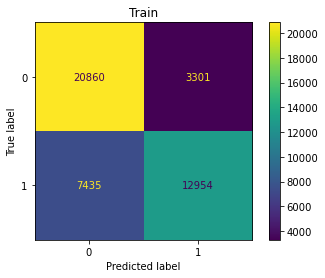

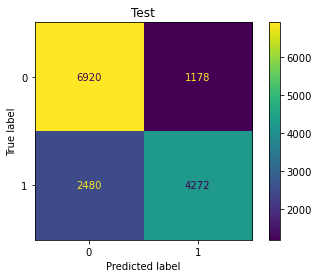

In [31]:
log_reg_pipe.run_all(X_train_run=X_train, X_test_run=X_test, y_train_run=y_train, y_test_run=y_test, train_results=True);

### Logistic Regression Grid Search

During my initial fitting of the Logistic Regression model, the notebook provided a warning that the model failed to converge based on the `solver` chosen. As such, I have set up a gridsearch with cross validation to determine the best solver for the job.

`Liblinear` is the best `solver` for this particular dataset. The train data and test data scores were almost identical, indicating that there is a good fit with little over/underfitting. 

In [32]:
log_params = {
    'logreg__solver':['liblinear', 'sag', 'saga']
}

In [33]:
log_reg_gs = GridSearchCV(estimator=log_reg_model, param_grid=log_params, cv=10, verbose=1)

In [34]:
log_reg_gs.fit(X_train, y_train);

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\nacnu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which

In [35]:
log_reg_gs.best_params_

{'logreg__solver': 'liblinear'}

In [36]:
log_reg_gs.best_score_

0.7568799102132435

In [37]:
log_reg_gs.best_estimator_.score(X_test,y_test)

0.7536700336700337

### Next Iteration of Gridsearch

The last gridsearch run let me identify the best `solver` for the dataset: `Liblinear`. On this next iteration, I also wanted to review the best `max_iter`.

The test results came back the same: max iterations 100 (the default), and `liblinear` as the best solver. I will use this as the default solver moving forward.

In [38]:
log_params2 = {
    'logreg__solver':['liblinear'],
    'logreg__max_iter':[100, 150, 200],
}

In [39]:
log_reg_gs2 = GridSearchCV(estimator=log_reg_model, param_grid=log_params2, cv=5, verbose=1)

In [40]:
log_reg_gs2.fit(X_train, y_train);

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   15.1s finished


In [41]:
log_reg_gs2.best_params_

{'logreg__max_iter': 100, 'logreg__solver': 'liblinear'}

In [42]:
log_reg_gs2.best_score_

0.757037037037037

In [43]:
log_reg_gs2.best_estimator_.score(X_test,y_test)

0.7536700336700337

### Final Logistic Regression Model

After running several GridSearches, the final model for logistic regression is below. This is not a great model and is almost identical to my baseline logistic regression model. 

In [44]:
log_reg_model_final = Pipeline([
    ('ColTrans', ColTrans),
    ('logreg', LogisticRegression(solver='liblinear', random_state=42))
])

In [45]:
start1 = perf_counter()
log_reg_model_final.fit(X_train, y_train);
end1 = perf_counter()

In [46]:
log_reg_pipe_final = ModelRuns(log_reg_model_final, 'logreg', X_train, y_train)

Train Report: 
              precision    recall  f1-score   support

           0       0.74      0.86      0.80     24161
           1       0.80      0.63      0.71     20389

    accuracy                           0.76     44550
   macro avg       0.77      0.75      0.75     44550
weighted avg       0.76      0.76      0.75     44550

ROC-AUC Score:0.827420488192703

Test Report: 
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      8098
           1       0.78      0.63      0.70      6752

    accuracy                           0.75     14850
   macro avg       0.76      0.74      0.75     14850
weighted avg       0.76      0.75      0.75     14850

ROC-AUC Score:0.8200432403003959


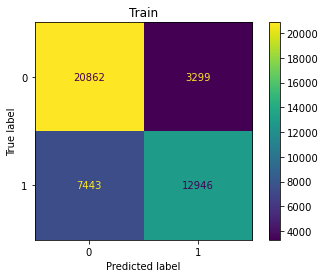

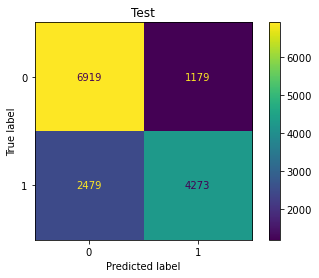

In [47]:
start2 = perf_counter()
log_reg_pipe_final.run_all(X_train_run=X_train, X_test_run=X_test, y_train_run=y_train, y_test_run=y_test, train_results=True);
end2 = perf_counter()

In [48]:
log_reg_time = (end1-start1 + end2 - start2)

In [49]:
record_results('logreg', log_reg_model_final, time_dic, log_reg_time, acc_dic, roc_auc_dic)

## K-Nearest Neighbor

My K-Nearest Neighbor model has 86% accuracy and an ROC-AUC score of 94% on the training data while the test results have an accuracy of 79% and ROC-AUC score of 86%. This is indicative of overfitting and I will look to reduce overfitting by adjusting hyperparameters through gridsearch.

Overall, these results are pretty good though.

In [50]:
knn_model = Pipeline([
    ('ColTrans', ColTrans),
    ('knn', KNeighborsClassifier())
])

In [51]:
knn_model.fit(X_train, y_train);

In [52]:
knn_pipe = ModelRuns(knn_model, 'knn', X_train, y_train)

In [ ]:
knn_pipe.run_all(X_train_run=X_train, X_test_run=X_test, y_train_run=y_train, y_test_run=y_test, train_results=True);

### K-Nearest Neighbors GridSearch

My KNN model is overfit, I will use GridSearch to attempt to reduce overfitting the training data and increase my score results on the test data. I will begin the search by adjusting `n_neighbors` and `weights`.

In [ ]:
knn_params = {
    'knn__n_neighbors':[5, 7, 9],
    'knn__weights':['uniform', 'distance']
}
knn_gs = GridSearchCV(estimator=knn_model, param_grid=knn_params, cv=5, verbose=1)
knn_gs.fit(X_train, y_train);

In [ ]:
knn_gs.best_params_

In [ ]:
knn_gs.best_score_

In [ ]:
knn_gs.best_estimator_.score(X_test,y_test)

### Second Iteration of K-Nearest Neighbors GridSearch

`Distance` is the best `weight` for the KNN model and the best `n_neighbors` is 9. 9 was at the upper end of my spectrum though and I will continue to increase the values in my next iteration. I will also look to further tune the model by adjusting the `p` hyperparameter.

I tried several different times to find the best `n_neighbors` using GridSearch. While the model improved as the number increased, the improvement was minimal when the amount of runtime was considered. As such, I have decided to use 13 as the `n_neighbors` for this model.

Results of the second iteration indicate:
   - `n_neighbors` is 13
   - `weights` is `distance`
   - `p` is 1

In [ ]:
knn_params2 = {
    'knn__n_neighbors':[9, 11, 13],
    'knn__weights':['distance'],
    'knn__p':[1, 2]
}
knn_gs2 = GridSearchCV(estimator=knn_model, param_grid=knn_params2, cv=5, verbose=1)
knn_gs2.fit(X_train, y_train);

In [ ]:
knn_gs2.best_params_

In [ ]:
knn_gs2.best_score_

In [ ]:
knn_gs2.best_estimator_.score(X_test,y_test)

### Final K-Nearest Neighbors Model

The Final K-Nearest Neighbors Model increase accuracy from 79% to 80% and ROC-AUC score from 86% to 88% on test data. 

The model is even more overfit on the training data as well. Given more time, this could use additional tweaking.

In [ ]:
knn_model_final = Pipeline([
    ('ColTrans', ColTrans),
    ('knn', KNeighborsClassifier(n_neighbors=13, p=1, weights='distance'))
])

In [ ]:
start1 = perf_counter()
knn_model_final.fit(X_train, y_train);
end1 = perf_counter()

In [ ]:
knn_pipe_final = ModelRuns(knn_model_final, 'knn', X_train, y_train)

In [ ]:
start2 = perf_counter()
knn_pipe_final.run_all(X_train_run=X_train, X_test_run=X_test, y_train_run=y_train, y_test_run=y_test, train_results=True);
end2 = perf_counter()

In [ ]:
knn_time = (end1-start1 + end2 - start2)
# time_dic['knn'] = knn_time

In [ ]:
record_results('knn', knn_model_final, time_dic, knn_time, acc_dic, roc_auc_dic)

### K-Means and K-Nearest Neighbor

For this method, I utilize unsupervised learning K-Means in conjunction with K-Nearest Neighbors. I have a loop to create a table utilizing 1-7 clusters, then separate the predictor data based on the cluster results. I then run K-Nearest Neighbors on each of the cluster groupings to determine if clustering helps the dataset. When the number of clusters is set to 1, it is the same as running K-Nearest Neighbors without clustering. 

The results of the model show that it is more beneficial to skip K-Means Clustering altogether. 

In [ ]:
df_names = ['kmeans_0', 'kmeans_1', 'kmeans_2', 'kmeans_3', 'kmeans_4', 
            'kmeans_5', 'kmeans_6']
main_col = ['cluster_group']
kmeans_results_df = pd.DataFrame(df_names, columns=main_col)

for i in range(1,8):
    kmeans_model = Pipeline([
        ('ColTrans', ColTrans),
        ('kmeans', KMeans(n_clusters=i, random_state=42))
    ])
    
    
    # Fitting the model
    kmeans_model.fit(X_train, y_train);
    
    # creating a dataframe for X_train so I can house the cluster data
    kmeans_X_train_df = pd.DataFrame(X_train).copy()
    
    
    # predicting data before adding back the target var so there is no data leakage 
    kmeans_X_train_df['cluster'] = kmeans_model.predict(X_train)

    
    # adding the target variable back so that I can then separate into dfs based on clusters
    kmeans_X_train_df['target'] = y_train.copy()
    
#     print(kmeans_X_train_df)
    
    # creating new dataframes based on clusters and storing in a dictionary
    kmeans_train_dic = {}
    for x in range(i-i, i):
#         print(x)
#         print(df_names[x])
#         print(kmeans_X_train_df[kmeans_X_train_df['cluster'] == x])
        kmeans_train_dic[df_names[x]] = kmeans_X_train_df[kmeans_X_train_df['cluster'] == x]

        
    # need to seperate x, y vars now
    y_kmeans_train_dic = {}
    for x in range(i-i, i):
        y_kmeans_train_dic[df_names[x]] = kmeans_train_dic[df_names[x]].pop('target') 
        
    # creating a dataframe for X_test so I can house the cluster data
    kmeans_X_test_df = pd.DataFrame(X_test).copy()
    
    # predicting data before adding back the target var so there is no data leakage 
    kmeans_X_test_df['cluster'] = kmeans_model.predict(X_test)
    
    # adding the target variable back so that I can then separate into dfs based on clusters
    kmeans_X_test_df['target'] = y_test.copy()
    
    
    # creating new dataframes based on clusters and storing in a dictionary
    kmeans_test_dic = {}
    for x in range(i-i, i):
#         print(df_names[x])
        kmeans_test_dic[df_names[x]] = kmeans_X_test_df[kmeans_X_test_df['cluster'] == x]
        
    # need to seperate x, y vars now
    y_kmeans_test_dic = {}
    for x in range(i-i, i):
        y_kmeans_test_dic[df_names[x]] = kmeans_test_dic[df_names[x]].pop('target')
        
#     print(kmeans_train_dic)    
#     print(kmeans_test_dic)    
        
    # It works above this point
    # running the knn model on each cluster
    knn_model = Pipeline([
        ('ColTrans', ColTrans),
        ('knn', KNeighborsClassifier())
    ])
    
    # creating a dic to story each fitted model
    model_dic = {}
    for x in range(0, i):
        model_dic[df_names[x]] = knn_model.fit(kmeans_train_dic[df_names[x]], y_kmeans_train_dic[df_names[x]])
        
    # Creating a dic to store test scores
    knn_test_scores = {}
    for x in range(0, i):
        knn_test_scores[df_names[x]] = model_dic[df_names[x]].score(kmeans_test_dic[df_names[x]], y_kmeans_test_dic[df_names[x]])
        
    # creating a dataframe to store all test scores
#     main_col = ['cluster_group']
#     kmeans_results_df = pd.DataFrame(knn_test_scores.keys(), columns=main_col)
    
    # appending each itteration to df
    addition = pd.DataFrame({
        f'clusters={i}':  knn_test_scores.values()})
    
    kmeans_results_df = pd.concat([kmeans_results_df, addition], axis=1)

In [ ]:
kmeans_results_clean = kmeans_results_df.set_index('cluster_group').copy()
kmeans_results_clean

In [ ]:
for col in kmeans_results_clean.columns:
    print(f"{col} Accuracy: {np.mean(kmeans_results_df[col])})

## Decision Tree (DONE)

My decision tree model has 100% accuracy and an ROC-AUC score of 99.99% for the train data while the test results have an accuracy of 78% and an ROC-AUC score of 78%. This is indicative of overfitting and I will look to reduce overfitting by adjusting hyperparameters through gridsearch.

In [ ]:
dtc_model = Pipeline([
    ('ColTrans', ColTrans),
    ('dtc', DecisionTreeClassifier(random_state=42))
])

In [ ]:
dtc_model.fit(X_train, y_train);

In [ ]:
dtc_pipe = ModelRuns(dtc_model, 'dtc', X_train, y_train)

In [ ]:
dtc_pipe.run_all(X_train_run=X_train, X_test_run=X_test, y_train_run=y_train, y_test_run=y_test, train_results=True);

### Decision Tree GridSearch

My decision tree model was very overfit. I will look to adjust some of the hyperparameters to reduce overfitting, starting with `criterion` and `max_depth`.

In [ ]:
dtc_params = {
    'dtc__criterion':["gini", "entropy"],
    'dtc__max_depth':[4, 8, 16, 32, None]
}
dtc_gs = GridSearchCV(estimator=dtc_model, param_grid=dtc_params, cv=5, verbose=1)
dtc_gs.fit(X_train, y_train);

In [ ]:
dtc_gs.best_params_

In [ ]:
dtc_gs.best_score_

In [ ]:
dtc_gs.best_estimator_.score(X_test,y_test)

### Second Iteration of Decision Tree GridSearch

Entropy is the best solver for my Decision tree and I will use that for the second method. The best max depth is 32 which could be far off from the `None` category. I will adjust the max depth closer to 32 to see how it compares. I will also look to adjust `min_samples_split` to attempt to tune the tree further.

Results of GridSearch indicate:

   - `criterion` is `entropy`
   - `max_depth` is 34
   - `min_samples_split` is 3
   
   
I will use these features moving forward.

In [ ]:
dtc_params2 = {
    'dtc__criterion':["entropy"],
    'dtc__max_depth':[30, 31, 32, 33, 34, 35, 36],
    'dtc__min_samples_split': [2, 3, 4, 5, 6]
}
dtc_gs2 = GridSearchCV(estimator=dtc_model, param_grid=dtc_params2, cv=5, verbose=1)
dtc_gs2.fit(X_train, y_train);

In [ ]:
dtc_gs2.best_params_

In [ ]:
dtc_gs2.best_score_

In [ ]:
dtc_gs2.best_estimator_.score(X_test,y_test)

### Final Decision Tree Model

The Final Decision Tree Model does not change much from the baseline decision tree model. The main area of improvement is the ROC-AUC score being raised from 78% to 79%. 

The model is still overfit on the training data as well. Given more time, this could use additional tweaking. 

In [ ]:
dtc_model_final = Pipeline([
    ('ColTrans', ColTrans),
    ('dtc', DecisionTreeClassifier(criterion='entropy', max_depth=34, 
                                   min_samples_split=3, random_state=42))
])

In [ ]:
start1 = perf_counter()
dtc_model_final.fit(X_train, y_train);
end1 = perf_counter()

In [ ]:
dtc_pipe_final = ModelRuns(dtc_model_final, 'dtc', X_train, y_train)

In [ ]:
start2 = perf_counter()
dtc_pipe_final.run_all(X_train_run=X_train, X_test_run=X_test, y_train_run=y_train, y_test_run=y_test, train_results=True);
end2 = perf_counter()

In [ ]:
dtc_time = (end1-start1 + end2 - start2)
# time_dic['dtc'] = dtc_time

In [ ]:
record_results('dtc', dtc_model_final, time_dic, dtc_time, acc_dic, roc_auc_dic)

## Random Forest (DONE)

My random forest model has 100% accuracy and an ROC-AUC score of 99.95% for the train data while the test results have an accuracy of 82% and an ROC-AUC score of 89%. This is indicative of overfitting and I will look to reduce overfitting by adjusting hyperparameters through gridsearch.

Overall, these results are pretty good though. 

In [ ]:
rf_model = Pipeline([
    ('ColTrans', ColTrans),
    ('rf', RandomForestClassifier(random_state=42))
])

In [ ]:
rf_model.fit(X_train, y_train);

In [ ]:
rf_pipe = ModelRuns(rf_model, 'rf', X_train, y_train)

In [ ]:
rf_pipe.run_all(X_train_run=X_train, X_test_run=X_test, y_train_run=y_train, y_test_run=y_test, train_results=True);

### Random Forest GridSearch

My Random forest model is overfit, I will use GridSearch to attempt to reduce overfitting the training data and increase my score results on the test data. Just like with the decision tree model I am beginning with `criterion` and `max_depth`.

In [ ]:
rf_params = {
    'rf__criterion':["gini", "entropy", 'log_loss'],
    'rf__max_depth':[4, 16, 32, None]
}
rf_gs = GridSearchCV(estimator=rf_model, param_grid=rf_params, cv=5, verbose=1)
rf_gs.fit(X_train, y_train);

In [ ]:
rf_gs.best_params_

In [ ]:
rf_gs.best_score_

In [ ]:
rf_gs.best_estimator_.score(X_test,y_test)

### Second Iteration of GridSearch

After completing one GridSearch, I have decided to stick with the criterion: `entropy`. The best max depth is 32 which could be far off from the `None` category. I will adjust the max depth closer to 32 to see how it compares. I will also look to adjust `max_features` to attempt to tune the forest further.

Results of GridSearch indicate:

   - `criterion` is `entropy`
   - `max_depth` is 32
   - `max_features` is `log2`
   
   
I will use these features moving forward.

In [ ]:
rf_params2 = {
    'rf__criterion':["entropy"],
    'rf__max_depth':[31, 32, 33],
    'rf__max_features': ['auto', 'log2', None, .5]
}
rf_gs2 = GridSearchCV(estimator=rf_model, param_grid=rf_params2, cv=5, verbose=1)
rf_gs2.fit(X_train, y_train);

In [ ]:
rf_gs2.best_params_

In [ ]:
rf_gs2.best_score_

In [ ]:
rf_gs2.best_estimator_.score(X_test,y_test)

### Random Forest Final Model

The Final Random Forest Model does not change much from the baseline decision tree model. The main area of improvement is the ROC-AUC score being raised from 89.6% to 89.9%.

The model is still overfit on the training data as well. Given more time, this could use additional tweaking.

In [ ]:
rf_model_final = Pipeline([
    ('ColTrans', ColTrans),
    ('rf', RandomForestClassifier(criterion='entropy', max_depth=32, 
                                  max_features='log2', random_state=42))
])

In [ ]:
start1 = perf_counter()
rf_model_final.fit(X_train, y_train);
end1 = perf_counter()

In [ ]:
rf_pipe_final = ModelRuns(rf_model_final, 'rf', X_train, y_train)

In [ ]:
start2 = perf_counter()
rf_pipe_final.run_all(X_train_run=X_train, X_test_run=X_test, y_train_run=y_train, y_test_run=y_test, train_results=True);
end2 = perf_counter()

In [ ]:
rf_time = (end1-start1 + end2 - start2)
# time_dic['rf'] = rf_time

In [ ]:
record_results('rf', rf_model_final, time_dic, rf_time, acc_dic, roc_auc_dic)

## C-Support Vector Classification (SVC) (DONE)

This model takes a long time to run (over 20 minutes) and gives relatively similar results when compared to other models. For the train data, the accuracy is 80% and ROC-AUC score is 88%. For the test data, the accuracy is 79% and ROC-AUC score is 86%. 

The accuracy and ROC-AUC scores line up relatively well between train and test data indicating that there might be a slight overfitting but not significant ooverfitting.

Since the model takes so long to run and is relatively well fit, I will not be adjusting any of the hyperparameters of this model.

In [ ]:
SVC_model = Pipeline([
    ('ColTrans', ColTrans),
    ('SVC', SVC(probability=True, random_state=42))
])

In [ ]:
start1 = perf_counter()
SVC_model.fit(X_train, y_train);
end1 = perf_counter()

In [ ]:
SVC_pipe = ModelRuns(SVC_model, 'svc', X_train, y_train)

In [ ]:
start2 = perf_counter()
SVC_pipe.run_all(X_train_run=X_train, X_test_run=X_test, y_train_run=y_train, y_test_run=y_test, train_results=True);
end2 = perf_counter()

In [ ]:
svc_time = (end1-start1 + end2 - start2)
time_dic['SVC'] = svc_time

In [ ]:
record_results('svc', SVC_model, time_dic, svc_time, acc_dic, roc_auc_dic)

## Nu-Support Vector Classification (NuSVC) (DONE)

This model takes a long time to run (over 30 minutes) and gives relatively similar results when compared to other models. For the train data, the accuracy is 80% and ROC-AUC score is 88%. For the test data, the accuracy is 79% and ROC-AUC score is 86%. 

The accuracy and ROC-AUC scores line up relatively well between train and test data indicating that there might be a slight overfitting but not significant ooverfitting.

Since the model takes so long to run and is relatively well fit, I will not be adjusting any of the hyperparameters of this model.

In [ ]:
nu_model = Pipeline([
    ('ColTrans', ColTrans),
    ('NuSVC', NuSVC(probability=True, random_state=42))
])

In [ ]:
start1 = perf_counter()
nu_model.fit(X_train, y_train);
end1 = perf_counter()

In [ ]:
nu_pipe = ModelRuns(nu_model, 'NuSVC', X_train, y_train)

In [ ]:
start2 = perf_counter()
nu_pipe.run_all(X_train_run=X_train, X_test_run=X_test, y_train_run=y_train, y_test_run=y_test, train_results=True);
end2 = perf_counter()

In [ ]:
nusvc_time = (end1-start1 + end2 - start2)
time_dic['NuSVC'] = nusvc_time

In [ ]:
record_results('nu_svc', nu_model, time_dic, nusvc_time, acc_dic, roc_auc_dic)

## AdaBoost

My AdaBoost model has 75% accuracy and an ROC-AUC score of 83% on the training data while the test results have an accuracy of 74% and ROC-AUC score of 82%. The accuracy and ROC-AUC scores line up relatively well between train and test data indicating that there might be a slight overfitting but not significant ooverfitting.

In [ ]:
ada_model = Pipeline([
    ('ColTrans', ColTrans),
    ('ada', AdaBoostClassifier(random_state=42))
])

In [ ]:
ada_model.fit(X_train, y_train);

In [ ]:
ada_pipe = ModelRuns(ada_model, 'ada', X_train, y_train)

In [ ]:
ada_pipe.run_all(X_train_run=X_train, X_test_run=X_test, y_train_run=y_train, y_test_run=y_test, train_results=True);

### Adaboost GridSearch

My AdaBoost model is one of the worst baseline performing models in this analysis, though the level of overfitting is one of the least. I will look to adjust the hyperparameters and tune the model to improve performance.

In [ ]:
ada_params = {
    'ada__n_estimators':[25, 50, 100],
    'ada__learning_rate':[0.5, 1, 2],

}
ada_gs = GridSearchCV(estimator=ada_model, param_grid=ada_params, cv=5, verbose=1)
ada_gs.fit(X_train, y_train)

In [ ]:
ada_gs.best_params_

In [ ]:
ada_gs.best_score_

In [ ]:
ada_gs.best_estimator_.score(X_test,y_test)

### Second Iteration of GridSearch

A `learning_rate` of 1 is the best for the AdaBoost model and the best `n_estimators` is 100. 100 was at the upper end of my spectrum though and I will continue to increase the values in my next iteration. I will also look to further tune the model by adjusting the `algorithm` hyperparameter.

I tried several different times to find the best `n_estimators` using GridSearch. While the model improved as the number increased, the improvement was minimal when the amount of runtime was considered. As such, I have decided to use 200 as the `n_estimators` for this model.

Results of the second iteration indicate:
   - `n_estimators` is 200
   - `learning_rate` is 1
   - `algorithm` is `SAMME.R`

In [ ]:
ada_params2 = {
    'ada__n_estimators':[100, 150, 200],
    'ada__learning_rate':[1],
    'ada__algorithm':['SAMME', 'SAMME.R']

}
ada_gs2 = GridSearchCV(estimator=ada_model, param_grid=ada_params2, cv=5, verbose=1)
ada_gs2.fit(X_train, y_train)

In [ ]:
ada_gs2.best_params_

In [ ]:
ada_gs2.best_score_

In [ ]:
ada_gs2.best_estimator_.score(X_test,y_test)

### AdaBoost Final Model

In [ ]:
ada_model_final = Pipeline([
    ('ColTrans', ColTrans),
    ('ada', AdaBoostClassifier(n_estimators=200, learning_rate=1, 
                               algorithm='SAMME.R', random_state=42))
])

In [ ]:
start1 = perf_counter()
ada_model_final.fit(X_train, y_train);
end1 = perf_counter()

In [ ]:
ada_pipe_final = ModelRuns(ada_model_final, 'ada', X_train, y_train)

In [ ]:
start2 = perf_counter()
ada_pipe_final.run_all(X_train_run=X_train, X_test_run=X_test, y_train_run=y_train, y_test_run=y_test, train_results=True);
end2 = perf_counter()

In [ ]:
ada_time = (end1-start1 + end2 - start2)

In [ ]:
record_results('ada', ada_model_final, time_dic, ada_time, acc_dic, roc_auc_dic)

## XGBoost

My XGBoost model has 85% accuracy and an ROC-AUC score of 93% on the training data while the test results have an accuracy of 81% and ROC-AUC score of 89%. The accuracy and ROC-AUC scores line up relatively well between train and test data indicating that there might be a slight overfitting but not significant ooverfitting.

In [28]:
xgb_model = Pipeline([
    ('ColTrans', ColTrans),
    ('xgb', xgboost.XGBClassifier(random_state=42))
])

In [29]:
xgb_model.fit(X_train, y_train);

In [30]:
xgb_pipe = ModelRuns(xgb_model, 'xgb', X_train, y_train)

Train Report: 
              precision    recall  f1-score   support

           0       0.83      0.92      0.87     24161
           1       0.89      0.77      0.83     20389

    accuracy                           0.85     44550
   macro avg       0.86      0.85      0.85     44550
weighted avg       0.86      0.85      0.85     44550

ROC-AUC Score:0.9323250501758836

Test Report: 
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      8098
           1       0.83      0.73      0.78      6752

    accuracy                           0.81     14850
   macro avg       0.81      0.80      0.80     14850
weighted avg       0.81      0.81      0.81     14850

ROC-AUC Score:0.8892590499789896


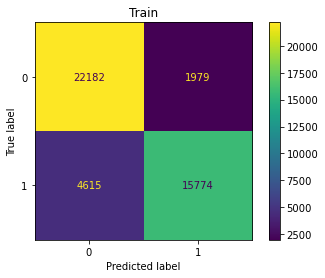

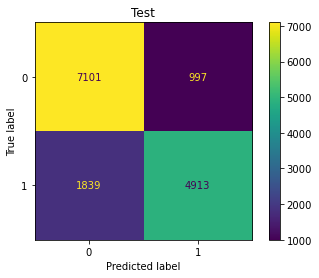

In [31]:
xgb_pipe.run_all(X_train_run=X_train, X_test_run=X_test, y_train_run=y_train, y_test_run=y_test, train_results=True);

### XGBoost Gridsearch

XGBoost is one of the best models I have so far. I will look to further tune it by checking `max_depth` and `booster` on the first iteration of GridSearch.

In [ ]:
xgboost.XGBClassifier()

In [33]:
xgb_params = {
    'xgb__max_depth':[10, 20, 30, 40],
    'xgb__booster':['gbtree', 'gblinear', 'dart']
}
xgb_gs = GridSearchCV(estimator=xgb_model, param_grid=xgb_params, cv=5, verbose=1)
xgb_gs.fit(X_train, y_train);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[20:55:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:55:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pa

[20:56:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:56:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pa

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.4min finished


In [34]:
xgb_gs.best_params_

{'xgb__booster': 'gbtree', 'xgb__max_depth': 10}

In [35]:
xgb_gs.best_score_

0.8161616161616161

In [36]:
xgb_gs.best_estimator_.score(X_test,y_test)

0.8191919191919191

### Second Iteration of GridSearch

The XGBoost `booster` `gbtree` is best for this model and the best `max_depth` is 10. 10 was at the lower end of my spectrum though and I will continue to decrease the values in my next iteration. I will also look to further tune the model by adjusting the `objective` hyperparameter.

Results of the second iteration indicate:
   - `booster` is `gbtree`
   - `max_depth` is 10
   - `objective` is `binary:logistic`

In [37]:
xgb_params2 = {
    'xgb__max_depth':[1, 5, 6, 10],
    'xgb__booster':['gbtree'],
    'xgb__objective':['binary:logistic', 'binary:logitraw', 'binary:hinge']
}
xgb_gs2 = GridSearchCV(estimator=xgb_model, param_grid=xgb_params2, cv=5, verbose=1)
xgb_gs2.fit(X_train, y_train);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[21:07:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:07:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:07:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are onl

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.7min finished


In [38]:
xgb_gs2.best_params_

{'xgb__booster': 'gbtree',
 'xgb__max_depth': 10,
 'xgb__objective': 'binary:logistic'}

In [39]:
xgb_gs2.best_score_

0.8161616161616161

In [40]:
xgb_gs2.best_estimator_.score(X_test,y_test)

0.8191919191919191

### XGBoost Final Model

## XGBoost Random Forest

In [ ]:
xgbrf_model = Pipeline([
    ('ColTrans', ColTrans),
    ('xgbrf', xgboost.XGBRFClassifier(random_state=42))
])

In [ ]:
xgbrf_model.fit(X_train, y_train);

In [ ]:
xgbrf_pipe = ModelRuns(xgbrf_model, 'xgbrf', X_train, y_train)

In [ ]:
xgb_pipe.run_all(X_train_run=X_train, X_test_run=X_test, y_train_run=y_train, y_test_run=y_test, train_results=True);

## Stacking Classifier 

In [ ]:
estimators = [
    ('lr', LogisticRegression(random_state=42, solver='liblinear')), 
    ('knn', KNeighborsClassifier()),
    ('dtc', DecisionTreeClassifier(random_state=42)),
    ('rfc', RandomForestClassifier(random_state=42)),
    ('ada', AdaBoostClassifier(random_state=42)),
    ('xgb', xgboost.XGBClassifier(random_state=42)),
    ('xgbrf', xgboost.XGBRFClassifier(random_state=42))
]

In [ ]:
stack_model = Pipeline([
    ('ColTrans', ColTrans),
    ('stack', StackingClassifier(estimators))
])

In [ ]:
stack_model.fit(X_train, y_train);

In [ ]:
stack_pipe = ModelRuns(stack_model, 'stack', X_train, y_train)

In [ ]:
stack_pipe.run_all(X_train_run=X_train, X_test_run=X_test, y_train_run=y_train, y_test_run=y_test, train_results=True);

## Final Stacking Model

In [ ]:
# estimators_final = [
#     ('lr', LogisticRegression(random_state=42, solver='liblinear')), 
#     ('knn', KNeighborsClassifier()),
#     ('dtc', DecisionTreeClassifier(criterion='entropy', max_depth=34, 
#                                    min_samples_split=3, random_state=42)),
#     ('rfc', RandomForestClassifier(criterion='entropy', max_depth=32, 
#                                   max_features='log2', random_state=42)),
#     ('svc', SVC(probability=True, random_state=42)),
#     ('NuSVC', NuSVC(probability=True, random_state=42))
#     ('ada', AdaBoostClassifier(random_state=42)),
#     ('xgb', xgboost.XGBClassifier(random_state=42)),
#     ('xgbrf', xgboost.XGBRFClassifier(random_state=42))
# ]

# Results

This analysis has run dozens of models to predict Tanzanian Water Wells in need of repair. Several factors were taken into consideration in choosing a final model:

- Runtime
    - Is it feasible to utilize the model on a larger scale?
- Accuracy
    - How accurate is the model?
- ROC-AUC score
    - How does the model perform when looking at true positive rates and true negative rates?

## Creating Results Table

In [ ]:
stop

# KMeans and KNN

For this method, I utilize unsupervised learning k-means in conjunction with K-Nearest Neighbors. I have a loop to create a table utilizing 1-7 clusters, then separate the predictor data based on the cluster results. I then run K-nearest Neighbors on each of the cluster groupings to determine if clustering helps the dataset. When the number of clusters is set to 1, it is the same as running K-Nearest Neighbors without clustering. 

The results of the model show that it is more beneficial to skip K-Means Clustering altogether. 

In [ ]:
df_names = ['kmeans_0', 'kmeans_1', 'kmeans_2', 'kmeans_3', 'kmeans_4', 
            'kmeans_5', 'kmeans_6']
main_col = ['cluster_group']
kmeans_results_df = pd.DataFrame(df_names, columns=main_col)

for i in range(1,8):
    kmeans_model = Pipeline([
        ('ColTrans', ColTrans),
        ('kmeans', KMeans(n_clusters=i, random_state=42))
    ])
    
    
    # Fitting the model
    kmeans_model.fit(X_train, y_train);
    
    # creating a dataframe for X_train so I can house the cluster data
    kmeans_X_train_df = pd.DataFrame(X_train).copy()
    
    
    # predicting data before adding back the target var so there is no data leakage 
    kmeans_X_train_df['cluster'] = kmeans_model.predict(X_train)

    
    # adding the target variable back so that I can then separate into dfs based on clusters
    kmeans_X_train_df['target'] = y_train.copy()
    
#     print(kmeans_X_train_df)
    
    # creating new dataframes based on clusters and storing in a dictionary
    kmeans_train_dic = {}
    for x in range(i-i, i):
#         print(x)
#         print(df_names[x])
#         print(kmeans_X_train_df[kmeans_X_train_df['cluster'] == x])
        kmeans_train_dic[df_names[x]] = kmeans_X_train_df[kmeans_X_train_df['cluster'] == x]

        
    # need to seperate x, y vars now
    y_kmeans_train_dic = {}
    for x in range(i-i, i):
        y_kmeans_train_dic[df_names[x]] = kmeans_train_dic[df_names[x]].pop('target') 
        
    # creating a dataframe for X_test so I can house the cluster data
    kmeans_X_test_df = pd.DataFrame(X_test).copy()
    
    # predicting data before adding back the target var so there is no data leakage 
    kmeans_X_test_df['cluster'] = kmeans_model.predict(X_test)
    
    # adding the target variable back so that I can then separate into dfs based on clusters
    kmeans_X_test_df['target'] = y_test.copy()
    
    
    # creating new dataframes based on clusters and storing in a dictionary
    kmeans_test_dic = {}
    for x in range(i-i, i):
#         print(df_names[x])
        kmeans_test_dic[df_names[x]] = kmeans_X_test_df[kmeans_X_test_df['cluster'] == x]
        
    # need to seperate x, y vars now
    y_kmeans_test_dic = {}
    for x in range(i-i, i):
        y_kmeans_test_dic[df_names[x]] = kmeans_test_dic[df_names[x]].pop('target')
        
#     print(kmeans_train_dic)    
#     print(kmeans_test_dic)    
        
    # It works above this point
    # running the knn model on each cluster
    knn_model = Pipeline([
        ('ColTrans', ColTrans),
        ('knn', KNeighborsClassifier())
    ])
    
    # creating a dic to story each fitted model
    model_dic = {}
    for x in range(0, i):
        model_dic[df_names[x]] = knn_model.fit(kmeans_train_dic[df_names[x]], y_kmeans_train_dic[df_names[x]])
        
    # Creating a dic to store test scores
    knn_test_scores = {}
    for x in range(0, i):
        knn_test_scores[df_names[x]] = model_dic[df_names[x]].score(kmeans_test_dic[df_names[x]], y_kmeans_test_dic[df_names[x]])
        
    # creating a dataframe to store all test scores
#     main_col = ['cluster_group']
#     kmeans_results_df = pd.DataFrame(knn_test_scores.keys(), columns=main_col)
    
    # appending each itteration to df
    addition = pd.DataFrame({
        f'clusters={i}':  knn_test_scores.values()})
    
    kmeans_results_df = pd.concat([kmeans_results_df, addition], axis=1)

In [ ]:
kmeans_results_clean = kmeans_results_df.set_index('cluster_group').copy()

In [ ]:
kmeans_results_clean

In [ ]:
for col in kmeans_results_clean.columns:
    print(np.mean(kmeans_results_df[col]))

## Standard KNN

In [ ]:
knn_model = Pipeline([
    ('ColTrans', ColTrans),
    ('knn', KNeighborsClassifier())
])

In [ ]:
knn_model.fit(X_train, y_train);

In [ ]:
knn_pipe = ModelRuns(knn_model, 'knn', X_train, y_train)

In [ ]:
knn_pipe.run_all(X_train_run=X_train, X_test_run=X_test, y_train_run=y_train, y_test_run=y_test, train_results=True);

In [ ]:
stop

In [ ]:
class ModelRuns():
    ''' Class to easily run models through and determine output.'''
    
    def __init__(self, model, model_name, X, y):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        
    def cross_val(self, X=None, y=None, cv=5):
        cv_X= X if X else self.X
        cv_y = y if y else self.y
        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=cv)
        self.cv_mean = np.mean(self.cv_results)
        return print(f"Cross_val mean is: {round(self.cv_mean, 4)} for kfold: {cv}")
                
    def accuracy(self, X, y):
        acc = self.model.score(X, y)
        
    def performance(self, X, y):
        y_pred = self.model.predict(X)
        report = classification_report(y, y_pred)
        return report
    
    def class_matrix(self, X, y):
        mat = plot_confusion_matrix(self.model, X, y);
        if X is X_train:
            plt.title("Train")
        elif X is X_test:
            plt.title('Test')
        else:
            plt.title('Class Matrix')
        return mat
    
    def roc_auc_custom(self, X, y):
        y_score = self.model.predict_proba(X)
        roc_score = roc_auc_score(y, y_score[:,1])
        return roc_score
    
    def run_all(self, X_train_run=X_train, X_test_run=X_test, y_train_run=y_train, y_test_run=y_test, train_results=True):
        if train_results:
            y_train_perf = self.performance(X_train_run, y_train_run)
            y_train_auc = self.roc_auc_custom(X_train_run, y_train_run)
            y_test_perf = self.performance(X_test_run, y_test_run)
            y_test_auc = self.roc_auc_custom(X_test_run, y_test_run)
            train_matrix = self.class_matrix(X_train_run, y_train_run)
            test_matrix = self.class_matrix(X_test_run, y_test_run)
            return print(f"Train Report: \n{y_train_perf}\nROC-AUC Score:{y_train_auc}\n"), \
            print(f"Test Report: \n{y_test_perf}\nROC-AUC Score:{y_test_auc}")
        else:
            y_test_perf = self.performance(X_test_run, y_test_run)
            test_matrix = self.class_matrix(X_test_run, y_test_run)
            return print(f"Test Report: \n{y_test_perf}")